In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import rlssm
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")


/Users/oguz/Desktop/thesis-project/venv/lib/python3.11/site-packages/pystan/lookup.py:10: UserWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html. The pkg_resources package is slated for removal as early as 2025-11-30. Refrain from using this package or pin to Setuptools<81.
  import pkg_resources


In [ ]:
file_path = 'online_data_for_matlab.txt'
df = pd.read_csv(file_path)
summary_stats_path = 'summary_stats_subs.txt'
df_summary = pd.read_csv(summary_stats_path, sep='\t')

print(f"Number of rows in trial-by-trial df: {len(df)}")
print(f"Number of rows in summary stats df: {len(df_summary)}")
display(df.head())
display(df_summary.head())
print(df.columns)
print(f"Number of unique subjects: {df['subject_id'].nunique()}")



Number of rows in trial-by-trial df: 30200
Number of rows in summary stats df: 151


,subject_id,practice_trial,trial,transition,reward,choice_1,choice_2,rt_1,rt_2,state
0,sub1,real,1,common,1,1,1,1131.480,1457.620,2
1,sub1,real,2,common,0,1,1,639.000,483.590,2
2,sub1,real,3,rare,0,2,1,264.190,718.195,2
3,sub1,real,4,common,1,2,2,302.265,1507.225,3
4,sub1,real,5,rare,1,2,2,321.685,1751.195,2


,subID,age_group,age,sex,acc,med_rt,med_rt_correct,se_rt,fast_rt,browser_interactions,inv_e,num_trials,WASI_rawVerbal,WASI_raw_MR,WASI_Verbal_T,WASI_MR_T,WASI_IQ
0,sub1,Older adolescents,17.055556,Female,0.580000,7706.355,6096.5650,786.576919,0,2,13286.818965,50,41.0,23.0,62.0,59.0,118.0
1,sub10,Mid adolescents,13.972222,Female,0.705882,12091.015,8909.4975,1337.221094,0,2,17128.937917,34,38.0,23.0,65.0,64.0,125.0
2,sub100,Children,10.716667,Female,0.400000,498.390,581.0950,81.462882,17,6,1245.975000,80,NaN,NaN,NaN,NaN,NaN
3,sub101,Adults,18.477778,Female,0.550000,4888.820,4566.1025,213.750206,0,1,8888.763636,80,NaN,NaN,NaN,NaN,NaN
4,sub102,Adults,18.247222,Female,0.400000,6510.925,5205.8700,1092.515091,0,1,16277.312500,45,NaN,NaN,NaN,NaN,NaN


Index(['subject_id', 'practice_trial', 'trial', 'transition', 'reward',
       'choice_1', 'choice_2', 'rt_1', 'rt_2', 'state'],
      dtype='object')
Number of unique subjects: 151


In [7]:
# Cell 3: Filter for a single subject and prep data for RLSSM
subject_id = 'sub1'
df_subj = df[df['subject_id'] == subject_id].copy()

df_subj['block_label'] = 1
df_subj['trial_block'] = df_subj['trial']
df_subj['rt'] = df_subj['rt_1'] / 1000
df_subj['accuracy'] = df_subj['reward']
df_subj['f_cor'] = 1
df_subj['f_inc'] = 0
df_subj['cor_option'] = 1
df_subj['inc_option'] = 2

fit_df = df_subj[['trial_block', 'f_cor', 'f_inc', 'cor_option', 'inc_option',
                  'block_label', 'rt', 'accuracy']].copy()
display(fit_df.head())


,trial_block,f_cor,f_inc,cor_option,inc_option,block_label,rt,accuracy
0,1,1,0,1,2,1,1.131480,1
1,2,1,0,1,2,1,0.639000,0
2,3,1,0,1,2,1,0.264190,0
3,4,1,0,1,2,1,0.302265,1
4,5,1,0,1,2,1,0.321685,1


In [11]:
fit_df = fit_df.loc[:, ~fit_df.columns.isin(['level_0', 'index'])]


In [13]:
print(fit_df.head(10))
print(fit_df.describe())
print("Unique values for each column:")
for col in fit_df.columns:
    print(col, fit_df[col].unique())


   index  trial_block  f_cor  f_inc  cor_option  inc_option  block_label  \
0      0            1      1      0           1           2            1   
1      1            2      1      0           1           2            1   
2      2            3      1      0           1           2            1   
3      3            4      1      0           1           2            1   
4      4            5      1      0           1           2            1   
5      5            6      1      0           1           2            1   
6      6            7      1      0           1           2            1   
7      7            8      1      0           1           2            1   
8      8            9      1      0           1           2            1   
9      9           10      1      0           1           2            1   

         rt  accuracy  accuracy_neg  
0  1.131480         1             1  
1  0.639000         0            -1  
2  0.264190         0            -1  
3  0.302265

In [15]:
import pandas as pd
from rlssm.models_DDM import RLDDModel

# Filter for a subject (e.g., 'sub1')
subject_id = 'sub1'
df_subj = df[df['subject_id'] == subject_id].copy()

# For RLDDModel, you may need these columns:
df_subj['block_label'] = 1
df_subj['trial_block'] = df_subj['trial']
df_subj['rt'] = df_subj['rt_2'] / 1000           # Stage 2 RT in seconds
df_subj['accuracy'] = df_subj['reward']          # Use reward as proxy for "accuracy" (not perfect, but works for testing)
df_subj['f_cor'] = 1                             # Dummy value for now
df_subj['f_inc'] = 0
df_subj['cor_option'] = 1
df_subj['inc_option'] = 2

fit_df = df_subj[['trial_block', 'f_cor', 'f_inc', 'cor_option', 'inc_option',
                  'block_label', 'rt', 'accuracy']].copy()


In [33]:
fit_df = fit_df[[col for col in fit_df.columns if col not in ['level_0', 'index']]]


In [20]:
print(fit_result.samples.keys())


Index(['chain', 'draw', 'transf_alpha', 'transf_drift_scaling',
       'transf_threshold', 'transf_ndt'],
      dtype='object')


In [21]:
for param in fit_result.samples:
    print(f"{param} mean:", fit_result.samples[param].mean())


chain mean: 0.0
draw mean: 49.5
transf_alpha mean: 0.4520445154419178
transf_drift_scaling mean: 8.613715173331075e-07
transf_threshold mean: 1.1066674273937047
transf_ndt mean: 0.2276481200081966


In [23]:
import numpy as np

def logistic(x):
    return 1 / (1 + np.exp(-x))

samples = fit_result.samples  # usually a DataFrame

alpha = logistic(samples['transf_alpha'])               # learning rate [0,1]
drift_scaling = np.exp(samples['transf_drift_scaling']) # drift rate (positive)
threshold = np.exp(samples['transf_threshold'])         # boundary separation (positive)
ndt = np.exp(samples['transf_ndt'])                     # non-decision time (positive)

print("Learning rate (alpha):", alpha.mean())
print("Drift scaling (v):", drift_scaling.mean())
print("Threshold (a):", threshold.mean())
print("Non-decision time (ndt):", ndt.mean())


Learning rate (alpha): 0.6100541797433207
Drift scaling (v): 1.000000861408456
Threshold (a): 3.026817672805732
Non-decision time (ndt): 1.2556611441470804


In [24]:
print("WAIC:", fit_result.waic)


WAIC: {'lppd': np.float64(-69.42748817692365), 'p_waic': np.float64(3.5797942224766937), 'waic': np.float64(146.01456479880068), 'waic_se': np.float64(29.76336096086186)}


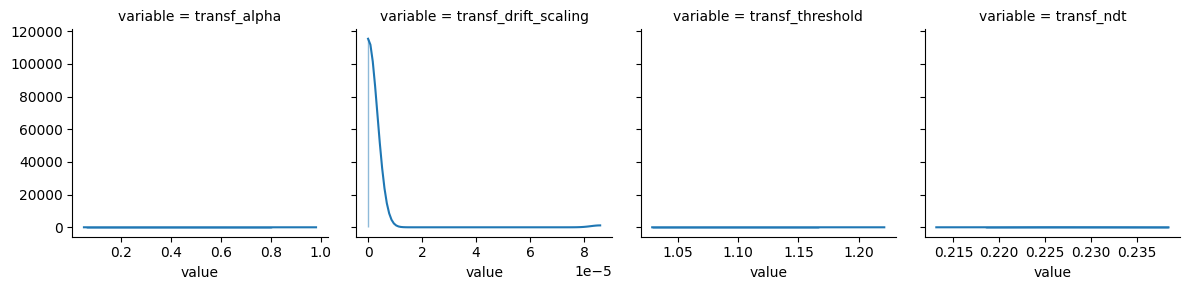

In [25]:
fit_result.plot_posteriors()
